# **Sistem Rekomendasi Film**

# **1.Import Library**

Mengimpor Library yang dibutuhkan dalam pembuatan model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD
from surprise.model_selection import train_test_split
from collections import defaultdict
from sklearn.metrics.pairwise import linear_kernel


# **2.Memuat Dataset dan Menggabungkan Data**

Memuat Dataset dan menggabungkan data dari movies_metadata.csv dengan ratings.csv

In [3]:
movies_df = pd.read_csv('data/movies_metadata.csv', low_memory=False)

ratings_df = pd.read_csv('data/ratings.csv')

print("Dataset berhasil dimuat.")
print(f"Jumlah data film: {len(movies_df)}")
print(f"Jumlah data rating: {len(ratings_df)}")

# Hapus baris dengan ID yang tidak valid di movies_df
movies_df = movies_df[movies_df['id'].str.isnumeric()]

# Ubah tipe data kolom 'id' agar bisa digabungkan
movies_df['id'] = movies_df['id'].astype(int)

# Ganti nama kolom 'id' agar konsisten dengan 'movieId' di ratings_df
movies_df.rename(columns={'id': 'movieId'}, inplace=True)

# Gabungkan ratings_df dengan kolom terpilih dari movies_df
movie_data = pd.merge(ratings_df, movies_df[['movieId', 'title', 'genres']], on='movieId', how='left')

# Menampilkan 5 baris pertama dari data gabungan
print("\nContoh data setelah digabung:")
print(movie_data.head())

Dataset berhasil dimuat.
Jumlah data film: 45466
Jumlah data rating: 26024289

Contoh data setelah digabung:
   userId  movieId  rating   timestamp                 title  \
0       1      110     1.0  1425941529     Three Colors: Red   
1       1      147     4.5  1425942435         The 400 Blows   
2       1      858     5.0  1425941523  Sleepless in Seattle   
3       1     1221     5.0  1425941546                   NaN   
4       1     1246     5.0  1425941556          Rocky Balboa   

                                              genres  
0  [{'id': 18, 'name': 'Drama'}, {'id': 9648, 'na...  
1                      [{'id': 18, 'name': 'Drama'}]  
2  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  
3                                                NaN  
4                      [{'id': 18, 'name': 'Drama'}]  


# **3.Exploratory Data Analysis (EDA)**

proses ini akan mencari tahu 10 film yang paling banyak menerima rating dari pengguna.

In [6]:
print("Movie_Data yang kosong berjumlah :", movie_data.isnull().sum())

movie_data.info()

Movie_Data yang kosong berjumlah : userId              0
movieId             0
rating              0
timestamp           0
title        14587721
genres       14587721
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26025358 entries, 0 to 26025357
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
 4   title      object 
 5   genres     object 
dtypes: float64(1), int64(3), object(2)
memory usage: 1.2+ GB


10 Film dengan Rating Terbanyak:
title
The Million Dollar Hotel              91082
Terminator 3: Rise of the Machines    87901
Solaris                               84318
The 39 Steps                          77045
Monsoon Wedding                       74355
Once Were Warriors                    67662
Three Colors: Red                     66512
License to Wed                        60024
48 Hrs.                               57416
The Passion of Joan of Arc            57232
Name: count, dtype: int64


C:\Users\fayiz_lgdvoec\AppData\Local\Temp\ipykernel_9536\535976268.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_movies.values, y=top_movies.index, palette='mako')


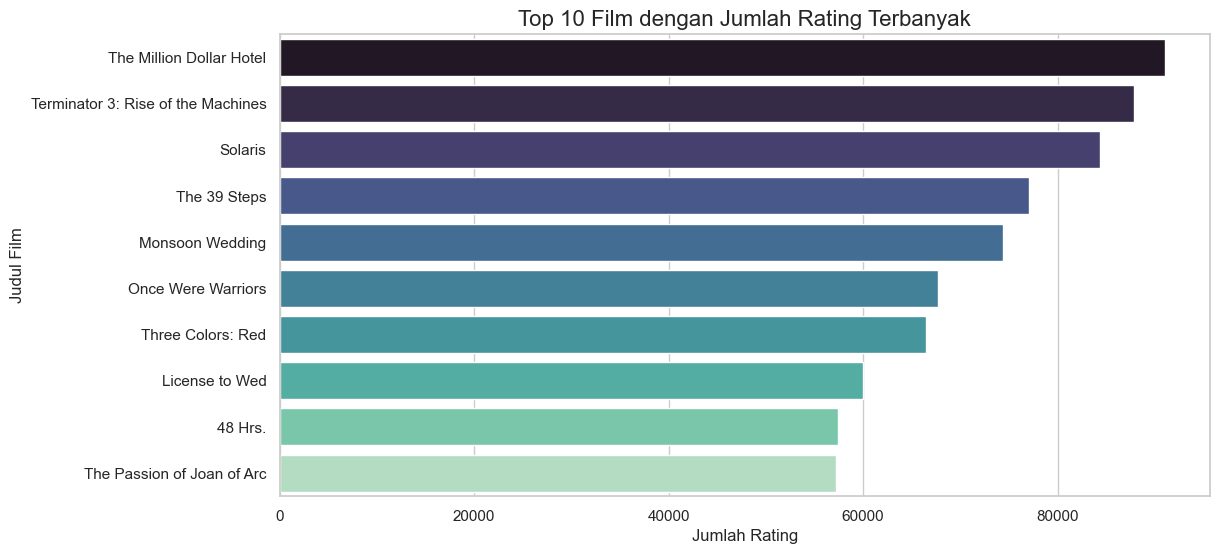

C:\Users\fayiz_lgdvoec\AppData\Local\Temp\ipykernel_9536\535976268.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=movie_data, palette='viridis')


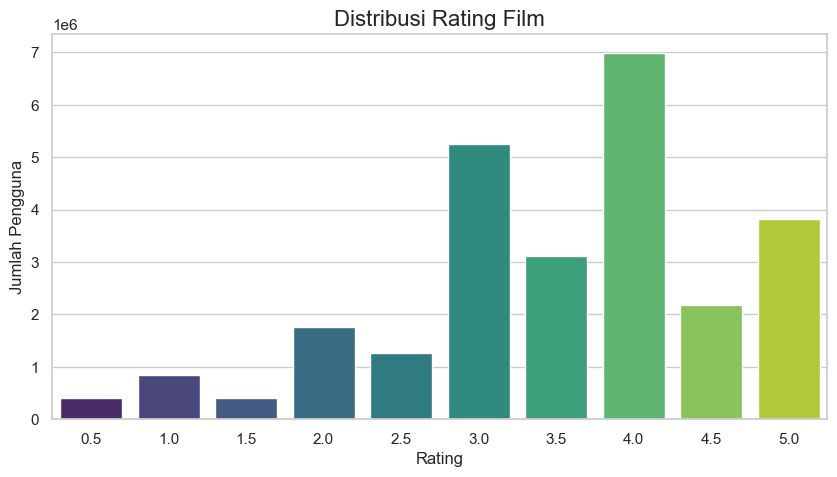

In [12]:
sns.set(style='whitegrid')

# Hitung jumlah rating untuk setiap film
top_movies = movie_data['title'].value_counts().head(10)

print("10 Film dengan Rating Terbanyak:")
print(top_movies)

# Buat plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_movies.values, y=top_movies.index, palette='mako')
plt.title('Top 10 Film dengan Jumlah Rating Terbanyak', fontsize=16)
plt.xlabel('Jumlah Rating')
plt.ylabel('Judul Film')
plt.savefig('top_10_movies.png')
plt.show()

# Buat plot distribusi rating
plt.figure(figsize=(10, 5))
sns.countplot(x='rating', data=movie_data, palette='viridis')
plt.title('Distribusi Rating Film', fontsize=16)
plt.xlabel('Rating')
plt.ylabel('Jumlah Pengguna')
plt.savefig('rating_distribution.png')
plt.show()

# **4. Persiapan Data Untuk Modeling**

**Persiapan Data untuk Model Content-Based Filtering**

Model ini hanya memerlukan informasi tentang film (item), khususnya movieId, title, dan genres. Kita akan membuat DataFrame baru yang bersih dan tidak ada duplikat film.

In [13]:
# Membuat DataFrame baru yang hanya berisi fitur film
movie_features = movies_df[['movieId', 'title', 'genres']].copy()

# Hapus duplikat film berdasarkan movieId
movie_features.drop_duplicates(subset='movieId', inplace=True)

# Setel movieId sebagai index untuk pencarian yang lebih cepat nanti
movie_features.set_index('movieId', inplace=True)

print("Data untuk Content-Based Filtering (movie_features):")
print(movie_features.head())

Data untuk Content-Based Filtering (movie_features):
                               title  \
movieId                                
862                        Toy Story   
8844                         Jumanji   
15602               Grumpier Old Men   
31357              Waiting to Exhale   
11862    Father of the Bride Part II   

                                                    genres  
movieId                                                     
862      [{'id': 16, 'name': 'Animation'}, {'id': 35, '...  
8844     [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...  
15602    [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...  
31357    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  
11862                       [{'id': 35, 'name': 'Comedy'}]  


In [14]:
# Hitung jumlah rating untuk setiap film
movie_rating_counts = movie_data['movieId'].value_counts()

# Pilih 15.000 film teratas dengan rating terbanyak
top_movie_ids = movie_rating_counts.head(15000).index

# Filter DataFrame movie_features agar hanya berisi film-film populer
movie_features_subset = movie_features.loc[movie_features.index.isin(top_movie_ids)]

print(f"Menggunakan subset data dengan {len(movie_features_subset)} film populer.")

Menggunakan subset data dengan 4276 film populer.


**Persiapan Data untuk Model Collaborative Filtering**

Model ini menggunakan library surprise yang memerlukan format data khusus. Kita perlu memuat data rating (userId, movieId, rating) menggunakan Reader dan Dataset dari surprise.

Karena dataset rating sangat besar (26 juta), untuk mempercepat proses training, kita bisa mengambil sampel data, misalnya 1 juta rating. Jika Anda menggunakan environment yang kuat (seperti Colab Pro atau mesin lokal yang mumpuni), Anda bisa menggunakan keseluruhan data.

In [15]:
# Mengambil sampel 1 juta rating untuk mempercepat proses
ratings_sample = ratings_df.sample(n=1000000, random_state=42)

# Membuat Reader untuk membaca skala rating dari 1 hingga 5
reader = Reader(rating_scale=(1, 5))

# Memuat data dari DataFrame ke format dataset surprise
# Pastikan urutan kolom adalah: user, item, rating
data_collaborative = Dataset.load_from_df(ratings_sample[['userId', 'movieId', 'rating']], reader)

print("Variabel 'data_collaborative' berhasil dibuat dan siap digunakan.")

Variabel 'data_collaborative' berhasil dibuat dan siap digunakan.


# **5.Membuat Model**

**Content-Based Filtering**

In [16]:
# Membuat matriks TF-IDF dari subset
movie_features_subset['genres'] = movie_features_subset['genres'].fillna('')
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix_subset = tfidf.fit_transform(movie_features_subset['genres'])

cosine_sim_subset = linear_kernel(tfidf_matrix_subset, tfidf_matrix_subset)

print("Matriks kemiripan untuk subset berhasil dibuat")

C:\Users\fayiz_lgdvoec\AppData\Local\Temp\ipykernel_9536\2821004745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_features_subset['genres'] = movie_features_subset['genres'].fillna('')


Matriks kemiripan untuk subset berhasil dibuat


In [17]:
def get_content_based_recommendations(title, cosine_sim_matrix=cosine_sim_subset, movie_features=movie_features_subset):
    indices = pd.Series(movie_features.index, index=movie_features['title']).drop_duplicates()
    try:
        idx = indices[title]
        # Dapatkan indeks lokal dari matriks subset
        local_idx = movie_features.index.get_loc(idx)
    except KeyError:
        return f"Film dengan judul '{title}' tidak ditemukan atau tidak termasuk dalam subset populer."

    sim_scores = list(enumerate(cosine_sim_matrix[local_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    
    movie_indices = [i[0] for i in sim_scores]
    return movie_features['title'].iloc[movie_indices]

In [25]:
# Dapatkan rekomendasi untuk salah satu film populer
recommendations = get_content_based_recommendations('The Dark Knight')
print("Rekomendasi Content-Based untuk 'The Dark Knight':")
print(recommendations)

Rekomendasi Content-Based untuk 'The Dark Knight':
movieId
6075          Carlito's Way
507             Killing Zoe
2088      Romeo Is Bleeding
832                       M
8838         Mercury Rising
2112                Payback
247             The Killing
26170        Coogan's Bluff
1619     The Way of the Gun
4639            Best Seller
Name: title, dtype: object


**Collaborative Filtering**

In [19]:
# Fungsi untuk menghitung Precision@k
def precision_recall_at_k(predictions, k=10, threshold=4.0):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
    
    return sum(prec for prec in precisions.values()) / len(precisions)

# Bagi data menjadi training dan testing
trainset, testset = train_test_split(data_collaborative, test_size=0.2)

# Inisialisasi dan latih model SVD
model_svd = SVD()
model_svd.fit(trainset)

# Lakukan prediksi pada test set
predictions = model_svd.test(testset)

# Hitung dan cetak Precision@10
precision_at_10 = precision_recall_at_k(predictions, k=10, threshold=4.0)
print(f"\nPrecision@10 untuk model SVD: {precision_at_10:.4f}")


Precision@10 untuk model SVD: 0.9230


In [22]:
def get_collaborative_recommendations(userId, model=model_svd, ratings_df=ratings_df, movie_features=movie_features):
    # Mendapatkan daftar semua movieId unik
    all_movie_ids = ratings_df['movieId'].unique()
    
    # Mendapatkan daftar film yang sudah ditonton oleh user
    movies_watched_by_user = ratings_df[ratings_df['userId'] == userId]['movieId']
    
    # Dapatkan daftar film yang BELUM ditonton oleh user
    movies_to_predict = np.setdiff1d(all_movie_ids, movies_watched_by_user)
    
    # Lakukan prediksi untuk film yang belum ditonton
    testset_for_user = [[userId, movie_id, 4.] for movie_id in movies_to_predict]
    predictions = model.test(testset_for_user)
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Ambil top 10 movieId
    top_10_movie_ids = [pred.iid for pred in predictions[:10]]
    
    # Memberi filter ID yang hanya ada di dalam indeks movie_features
    existing_ids = [movie_id for movie_id in top_10_movie_ids if movie_id in movie_features.index]

    top_10_movies = movie_features.loc[existing_ids]['title']
    return top_10_movies

In [23]:
# Dapatkan rekomendasi untuk user dengan ID 1
collab_recommendations = get_collaborative_recommendations(userId=1)
print("\nRekomendasi Collaborative Filtering untuk User ID 1:")
print(collab_recommendations)


Rekomendasi Collaborative Filtering untuk User ID 1:
movieId
318    The Million Dollar Hotel
Name: title, dtype: object
